In [24]:
import os
from dataclasses import dataclass
from typing import Dict, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import torch
import torch.nn as nn
import torch._dynamo

from pina import Condition, LabelTensor
from pina.domain import CartesianDomain
from pina.equation import Equation, FixedValue
from pina.model import FeedForward
from pina.operator import div, grad
from pina.problem import SpatialProblem
from pina.solver.physics_informed_solver import PINN
from pina.trainer import Trainer

# ---- Torch / dynamo boilerplate ----
torch._dynamo.config.disable = True
torch._dynamo.config.suppress_errors = True
os.environ.setdefault("TORCH_COMPILE_DISABLE", "1")

if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---- Matplotlib style ----
plt.rcParams.update({
    "figure.figsize": (7, 5),
    "image.origin": "lower",
    "axes.grid": False,
})


Using device: cuda


1. Geometry, grid, masks (shared FD + PINN)

Single‑electrode, single gauge, both centered at x=0.

In [25]:
# --- Geometry parameters (mm) ---
Lx_mm = 12.0           # total width
Lz_mm = 12.0           # total height

x_min, x_max = -Lx_mm / 2, Lx_mm / 2
z_min, z_max = 0.0, Lz_mm

contact_radius_mm = 0.025  # bottom electrode half-width (tiny contact)
# Widen the gauge to span the top (nearly full width)
gauge_radius_mm = Lx_mm / 2  # top gauge half-width

# --- Structured grid for FD baseline (and for PINN eval) ---
Nx = 241
Nz = 241

x = np.linspace(x_min, x_max, Nx)
z = np.linspace(z_min, z_max, Nz)
dx = float(x[1] - x[0])
dz = float(z[1] - z[0])

X, Z = np.meshgrid(x, z, indexing="ij")

j_bottom = 0
j_top    = Nz - 1

print(f"dx = {dx:.4f} mm, dz = {dz:.4f} mm  (grid: {Nx} x-nodes, {Nz} z-nodes)")


# --- 1D masks along x for bottom electrode & top gauge ---

def make_bottom_mask(center_mm: float, half_width_mm: float) -> np.ndarray:
    """Boolean mask over x for a bottom electrode strip."""
    return (x >= center_mm - half_width_mm) & (x <= center_mm + half_width_mm)

def make_top_mask(center_mm: float, half_width_mm: float) -> np.ndarray:
    """Boolean mask over x for a top gauge strip."""
    return (x >= center_mm - half_width_mm) & (x <= center_mm + half_width_mm)

electrode_center_mm = 0.0
gauge_center_mm     = 0.0

electrode_mask = make_bottom_mask(electrode_center_mm, contact_radius_mm)
gauge_mask     = make_top_mask(gauge_center_mm, gauge_radius_mm)


dx = 0.0500 mm, dz = 0.0500 mm  (grid: 241 x-nodes, 241 z-nodes)


In [26]:
# --- Finite-difference baseline (Jacobi solver + field helper) ---
def solve_laplace_fd(
    electrode_mask: np.ndarray,
    *,
    phi_electrode: float = 1.0,
    phi_gauge: float = 0.0,
    gauge_mask: Optional[np.ndarray] = None,
    gauge_mask_1d: Optional[np.ndarray] = None,
    max_iters: int = 8000,
    tol: float = 1e-5,
    verbose: bool = True,
) -> np.ndarray:
    gmask = gauge_mask_1d if gauge_mask_1d is not None else gauge_mask
    if gmask is None:
        gmask = globals().get("gauge_mask")
    if gmask is None:
        raise ValueError("Provide a gauge_mask or gauge_mask_1d.")
    phi = np.zeros((Nx, Nz), dtype=np.float64)
    electrode_idx = electrode_mask.astype(bool)
    gauge_idx = gmask.astype(bool)

    for it in range(max_iters):
        phi_old = phi.copy()
        phi[1:-1, 1:-1] = 0.25 * (
            phi_old[2:, 1:-1] + phi_old[:-2, 1:-1] +
            phi_old[1:-1, 2:] + phi_old[1:-1, :-2]
        )

        phi[~electrode_idx, j_bottom] = phi[~electrode_idx, j_bottom + 1]
        phi[electrode_idx, j_bottom] = phi_electrode

        phi[~gauge_idx, j_top] = phi[~gauge_idx, j_top - 1]
        phi[gauge_idx, j_top] = phi_gauge

        phi[0, :] = phi[1, :]
        phi[-1, :] = phi[-2, :]

        err = float(np.max(np.abs(phi - phi_old)))
        if verbose and it % 500 == 0:
            print(f"iter {it:5d}, max dphi = {err:.3e}")
        if err < tol:
            if verbose:
                print(f"Converged in {it} iterations (max dphi = {err:.3e})")
            break

    return phi


def compute_field(phi: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dphi_dx = np.zeros_like(phi)
    dphi_dz = np.zeros_like(phi)

    dphi_dx[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / (2 * dx)
    dphi_dx[0, :] = (phi[1, :] - phi[0, :]) / dx
    dphi_dx[-1, :] = (phi[-1, :] - phi[-2, :]) / dx

    dphi_dz[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2 * dz)
    dphi_dz[:, 0] = (phi[:, 1] - phi[:, 0]) / dz
    dphi_dz[:, -1] = (phi[:, -1] - phi[:, -2]) / dz

    Ex = -dphi_dx
    Ez = -dphi_dz
    Emag = np.sqrt(Ex**2 + Ez**2)
    return Ex, Ez, Emag


In [27]:
def plot_field_map(
    Emag: np.ndarray,
    Ex: np.ndarray,
    Ez: np.ndarray,
    *,
    title: str,
    electrode_mask_1d: np.ndarray = electrode_mask,
    gauge_mask_1d: np.ndarray = gauge_mask,
    step: int = 6,
    cmap: str = "plasma",
    vmax: Optional[float] = None,
    log_scale: bool = False,
    floor: float = 1e-6,
) -> None:
    """Heatmap of |E| plus downsampled quiver, with electrode & gauge shown."""
    Xs = X[::step, ::step]
    Zs = Z[::step, ::step]
    Exs = Ex[::step, ::step]
    Ezs = Ez[::step, ::step]

    vmax = float(vmax) if vmax is not None else float(np.max(Emag) + 1e-12)
    min_positive = float(np.min(Emag[Emag > 0])) if np.any(Emag > 0) else floor
    if log_scale:
        norm = LogNorm(vmin=max(floor, min_positive), vmax=vmax)
        vmin = None
    else:
        norm = None
        vmin = 0.0

    fig, ax = plt.subplots(figsize=(7, 5))
    im = ax.imshow(
        Emag.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect="equal",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        norm=norm,
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('|E| (arb. units)')

    ax.quiver(
        Xs,
        Zs,
        Exs,
        Ezs,
        color="white",
        scale=40 * vmax,
        width=0.002,
    )

    # Bottom/top lines
    ax.axhline(z_min, color="k", linewidth=0.5)
    ax.axhline(z_max, color="k", linewidth=0.5)

    # Overlay electrode/gauge strips
    ax.plot(x[electrode_mask_1d], np.full(electrode_mask_1d.sum(), z_min),
            "c", lw=3, label="Electrode (phi=1)")
    ax.plot(x[gauge_mask_1d], np.full(gauge_mask_1d.sum(), z_max),
            "w", lw=3, label="Gauge (phi=0)")

    ax.set_xlabel("x (mm)")
    ax.set_ylabel("z (mm)")
    ax.set_title(title)
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()


def plot_field_lines(
    phi: np.ndarray,
    *,
    title: str,
    step: int = 4,
    density: float = 1.0,
    electrode_mask_1d: np.ndarray = electrode_mask,
    gauge_mask_1d: np.ndarray = gauge_mask,
    cmap: str = "plasma",
) -> None:
    """Streamplot-style field lines colored by |E|."""
    Ex, Ez, Emag = compute_field(phi)

    x_coarse = x[::step]
    z_coarse = z[::step]
    Ex_c = Ex.T[::step, ::step]
    Ez_c = Ez.T[::step, ::step]
    Emag_c = Emag.T[::step, ::step]

    fig, ax = plt.subplots(figsize=(7, 5))
    strm = ax.streamplot(
        x_coarse,
        z_coarse,
        Ex_c,
        Ez_c,
        color=Emag_c,
        cmap=cmap,
        density=density,
        linewidth=1.0,
        arrowsize=1.0,
    )
    cbar = fig.colorbar(strm.lines, ax=ax)
    cbar.set_label('|E| (arb. units)')

    ax.axhline(z_min, color="k", linewidth=0.5)
    ax.axhline(z_max, color="k", linewidth=0.5)
    ax.plot(x[electrode_mask_1d], np.full(electrode_mask_1d.sum(), z_min), "c", lw=3, label="Electrode (phi=1)")
    ax.plot(x[gauge_mask_1d], np.full(gauge_mask_1d.sum(), z_max), "w", lw=3, label="Gauge (phi=0)")

    ax.set_xlabel("x (mm)")
    ax.set_ylabel("z (mm)")
    ax.set_title(title)
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()

In [28]:
def plot_field_map(
    Emag: np.ndarray,
    Ex: np.ndarray,
    Ez: np.ndarray,
    *,
    title: str,
    electrode_mask_1d: np.ndarray = electrode_mask,
    gauge_mask_1d: np.ndarray = gauge_mask,
    step: int = 6,
    cmap: str = "plasma",
    vmax: Optional[float] = None,
    log_scale: bool = False,
    floor: float = 1e-6,
) -> None:
    """Heatmap of |E| plus downsampled quiver, with electrode & gauge shown."""
    Xs = X[::step, ::step]
    Zs = Z[::step, ::step]
    Exs = Ex[::step, ::step]
    Ezs = Ez[::step, ::step]

    vmax = float(vmax) if vmax is not None else float(np.max(Emag) + 1e-12)
    min_positive = float(np.min(Emag[Emag > 0])) if np.any(Emag > 0) else floor
    if log_scale:
        norm = LogNorm(vmin=max(floor, min_positive), vmax=vmax)
        vmin = None
    else:
        norm = None
        vmin = 0.0

    fig, ax = plt.subplots(figsize=(7, 5))
    im = ax.imshow(
        Emag.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect="equal",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        norm=norm,
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('|E| (arb. units)')

    ax.quiver(
        Xs,
        Zs,
        Exs,
        Ezs,
        color="white",
        scale=40 * vmax,
        width=0.002,
    )

    # Bottom/top lines
    ax.axhline(z_min, color="k", linewidth=0.5)
    ax.axhline(z_max, color="k", linewidth=0.5)

    # Overlay electrode/gauge strips
    ax.plot(x[electrode_mask_1d], np.full(electrode_mask_1d.sum(), z_min),
            "c", lw=3, label="Electrode (phi=1)")
    ax.plot(x[gauge_mask_1d], np.full(gauge_mask_1d.sum(), z_max),
            "w", lw=3, label="Gauge (phi=0)")

    ax.set_xlabel("x (mm)")
    ax.set_ylabel("z (mm)")
    ax.set_title(title)
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()


In [29]:
def plot_fd_vs_pinn_difference(
    phi_fd: np.ndarray,
    phi_pinn: np.ndarray,
    *,
    quantity: str = "phi",
    rel_floor: float = 1e-3,
    show_abs: bool = True,
) -> None:
    """
    Side-by-side comparison and error maps for either potential or |E|.
    quantity: "phi" or "|E|"
    rel_floor: floor on denominator to avoid huge relative errors in flat regions.
    show_abs: if True, include absolute error panel in addition to relative error.
    """
    if quantity == "phi":
        a = phi_fd
        b = phi_pinn
        label = "phi"
    elif quantity == "|E|":
        _, _, a_mag = compute_field(phi_fd)
        _, _, b_mag = compute_field(phi_pinn)
        a, b = a_mag, b_mag
        label = "|E|"
    else:
        raise ValueError("quantity must be 'phi' or '|E|'")

    diff = b - a
    abs_err = np.abs(diff)
    rel_base = np.maximum(np.abs(a), float(rel_floor))
    rel = diff / rel_base

    vmin = float(np.min(a))
    vmax = float(np.max(a))

    ncols = 4 if show_abs else 3
    fig, axes = plt.subplots(1, ncols, figsize=(18 if show_abs else 14, 4), sharex=True, sharey=True)
    axes = list(axes)

    im0 = axes[0].imshow(
        a.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect="equal",
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
    )
    axes[0].set_title(f"FD {label}")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(
        b.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect="equal",
        cmap="viridis",
        vmin=vmin,
        vmax=vmax,
    )
    axes[1].set_title(f"PINN {label}")
    fig.colorbar(im1, ax=axes[1])

    idx_rel = 3 if show_abs else 2
    if show_abs:
        abs_vmax = float(np.max(abs_err) + 1e-12)
        im_abs = axes[2].imshow(
            abs_err.T,
            extent=[x_min, x_max, z_min, z_max],
            aspect="equal",
            cmap="magma",
            vmin=0.0,
            vmax=abs_vmax,
        )
        axes[2].set_title(f"|{label}| absolute error")
        fig.colorbar(im_abs, ax=axes[2])

    rel_vmax = float(np.percentile(np.abs(rel), 99.5)) if np.any(rel) else 1.0
    rel_vmax = max(rel_vmax, 1e-6)
    im2 = axes[idx_rel].imshow(
        rel.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect="equal",
        cmap="coolwarm",
        vmin=-rel_vmax,
        vmax=rel_vmax,
    )
    axes[idx_rel].set_title(f"Relative error in {label} (floor={rel_floor})")
    fig.colorbar(im2, ax=axes[idx_rel])

    for ax in axes:
        ax.set_xlabel("x (mm)")
        ax.set_ylabel("z (mm)")

    fig.suptitle(f"FD vs PINN comparison for {label}", y=1.02)
    fig.tight_layout()
    plt.show()


4. PINN problem definition (one electrode, same geometry)

In [42]:
@dataclass(frozen=True)
class TowerA2DGeometry:
    x_bounds: Tuple[float, float] = (x_min, x_max)
    z_bounds: Tuple[float, float] = (z_min, z_max)
    electrode_center_mm: float = electrode_center_mm
    contact_halfwidth_mm: float = contact_radius_mm
    gauge_center_mm: float = gauge_center_mm
    gauge_halfwidth_mm: float = gauge_radius_mm
    near_region_halfwidth_mm: float = 0.5
    near_region_height_mm: float = .5

    def _clip_interval(self, center: float, half_width: float) -> Tuple[float, float]:
        lo = max(self.x_bounds[0], center - half_width)
        hi = min(self.x_bounds[1], center + half_width)
        if hi <= lo:
            raise ValueError("Interval collapsed; widen the half-width.")
        return float(lo), float(hi)

    @property
    def electrode_span(self) -> Tuple[float, float]:
        return self._clip_interval(self.electrode_center_mm, self.contact_halfwidth_mm)

    @property
    def gauge_span(self) -> Tuple[float, float]:
        return self._clip_interval(self.gauge_center_mm, self.gauge_halfwidth_mm)

    @property
    def near_region_bounds(self) -> Tuple[Tuple[float, float], Tuple[float, float]]:
        x_lo, x_hi = self._clip_interval(0.0, self.near_region_halfwidth_mm)
        z_lo = float(self.z_bounds[0])
        z_hi = float(min(self.z_bounds[1], self.near_region_height_mm))
        return (x_lo, x_hi), (z_lo, z_hi)


@dataclass(frozen=True)
class NeumannSegment:
    name: str
    axis: str
    normal_sign: int


def build_laplace_equation_2d(conductivity: float, axes=("x", "z")) -> Equation:
    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        grad_phi = grad(output_, input_, components=["phi"], d=list(axes)).tensor
        flux = conductivity * grad_phi
        labels = [f"J_{ax}" for ax in axes]
        flux_lt = LabelTensor(flux, labels=labels)
        divergence = div(flux_lt, input_, components=labels, d=list(axes))
        return divergence  # should be ~0

    return Equation(residual)


def build_neumann_equation_2d(
    axis: str,
    normal_sign: int,
    conductivity: float,
    target_flux: float = 0.0,
    axes=("x", "z"),
) -> Equation:
    axis_index = list(axes).index(axis)

    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        grad_phi = grad(output_, input_, components=["phi"], d=list(axes)).tensor
        component = grad_phi[:, axis_index]
        flux = -conductivity * normal_sign * component
        target = torch.full_like(flux, float(target_flux))
        return LabelTensor((flux - target).unsqueeze(-1), labels=["flux"])

    return Equation(residual)


4.1 PINN problem class (domains + conditions)

In [43]:
class TowerA2DProblem(SpatialProblem):
    output_variables = ["phi"]
    axes = ("x", "z")

    def __init__(
        self,
        geometry: TowerA2DGeometry,
        conductivity: float = 0.0002,  # S/mm; constant
        phi_electrode: float = 1.0,
        phi_gauge: float = 0.0,
    ) -> None:
        self.geometry = geometry
        self.conductivity = float(conductivity)
        self.phi_electrode = float(phi_electrode)
        self.phi_gauge = float(phi_gauge)
        self.domains, self.neumann_segments, self.dirichlet_domains = self._build_domains()
        self._spatial_domain = self.domains["interior"]
        self._conditions = self._build_conditions()
        super().__init__()

    def _build_domains(self):
        domains: Dict[str, CartesianDomain] = {}

        # Interior rectangles
        domains["interior"] = CartesianDomain(
            {"x": list(self.geometry.x_bounds), "z": list(self.geometry.z_bounds)}
        )
        (x_lo_near, x_hi_near), (z_lo_near, z_hi_near) = self.geometry.near_region_bounds
        domains["interior_near"] = CartesianDomain(
            {"x": [x_lo_near, x_hi_near], "z": [z_lo_near, z_hi_near]}
        )

        dirichlet_domains = []

        # Bottom electrode Dirichlet
        electrode_lo, electrode_hi = self.geometry.electrode_span
        domains["electrode_bc"] = CartesianDomain(
            {"x": [electrode_lo, electrode_hi], "z": self.geometry.z_bounds[0]}
        )
        dirichlet_domains.append("electrode_bc")

        # Top gauge Dirichlet
        gauge_lo, gauge_hi = self.geometry.gauge_span
        domains["gauge_bc"] = CartesianDomain(
            {"x": [gauge_lo, gauge_hi], "z": self.geometry.z_bounds[1]}
        )
        dirichlet_domains.append("gauge_bc")

        neumann_segments: list[NeumannSegment] = []
        x_min_loc, x_max_loc = self.geometry.x_bounds
        z_min_loc, z_max_loc = self.geometry.z_bounds

        def add_segment(
            name: str,
            *,
            x_range=None,
            z_range=None,
            const_x=None,
            const_z=None,
            axis="z",
            normal_sign=1,
        ):
            if x_range is not None and x_range[1] - x_range[0] <= 1e-9:
                return
            if z_range is not None and z_range[1] - z_range[0] <= 1e-9:
                return
            payload = {}
            if const_x is not None:
                payload["x"] = float(const_x)
            else:
                payload["x"] = [float(x_range[0]), float(x_range[1])]
            if const_z is not None:
                payload["z"] = float(const_z)
            else:
                payload["z"] = [float(z_range[0]), float(z_range[1])]
            domains[name] = CartesianDomain(payload)
            neumann_segments.append(NeumannSegment(name=name, axis=axis, normal_sign=normal_sign))

        # Bottom, excluding electrode strip
        add_segment(
            "bottom_left",
            x_range=(x_min_loc, electrode_lo),
            const_z=z_min_loc,
            axis="z",
            normal_sign=-1,
        )
        add_segment(
            "bottom_right",
            x_range=(electrode_hi, x_max_loc),
            const_z=z_min_loc,
            axis="z",
            normal_sign=-1,
        )

        # Top, excluding gauge strip
        add_segment(
            "top_left",
            x_range=(x_min_loc, gauge_lo),
            const_z=z_max_loc,
            axis="z",
            normal_sign=1,
        )
        add_segment(
            "top_right",
            x_range=(gauge_hi, x_max_loc),
            const_z=z_max_loc,
            axis="z",
            normal_sign=1,
        )

        # Side walls x = const
        add_segment(
            "left_wall",
            const_x=x_min_loc,
            z_range=self.geometry.z_bounds,
            axis="x",
            normal_sign=-1,
        )
        add_segment(
            "right_wall",
            const_x=x_max_loc,
            z_range=self.geometry.z_bounds,
            axis="x",
            normal_sign=1,
        )

        return domains, neumann_segments, dirichlet_domains

    def _build_conditions(self) -> Dict[str, Condition]:
        conditions: Dict[str, Condition] = {}

        # Interior PDE (global + near-electrode focus)
        conditions["pde"] = Condition(
            domain="interior",
            equation=build_laplace_equation_2d(self.conductivity, axes=self.axes),
        )
        conditions["pde_near"] = Condition(
            domain="interior_near",
            equation=build_laplace_equation_2d(self.conductivity, axes=self.axes),
        )

        # Dirichlet electrode / gauge
        conditions["electrode"] = Condition(
            domain="electrode_bc",
            equation=FixedValue(self.phi_electrode, components=["phi"]),
        )
        conditions["gauge"] = Condition(
            domain="gauge_bc",
            equation=FixedValue(self.phi_gauge, components=["phi"]),
        )

        # Neumann segments
        for seg in self.neumann_segments:
            eq = build_neumann_equation_2d(seg.axis, seg.normal_sign, self.conductivity, axes=self.axes)
            conditions[f"neumann:{seg.name}"] = Condition(domain=seg.name, equation=eq)

        return conditions

    @property
    def spatial_domain(self):
        return self._spatial_domain

    @property
    def conditions(self) -> Dict[str, Condition]:
        return self._conditions


4.2 Discretisation + model + training wrapper

In [44]:
def discretise_2d_problem(
    problem: TowerA2DProblem,
    *,
    interior_points: int = 20_000,
    interior_points_near: Optional[int] = None,
    dirichlet_points: int = 1024,
    neumann_points: int = 2048,
    interior_mode: str = "latin",   # latin hypercube sampling
    boundary_mode: str = "random",
) -> None:
    """Sample collocation points for interior, focused interior, and each boundary segment."""
    problem.discretise_domain(n=interior_points, mode=interior_mode, domains="interior")
    near_pts = interior_points_near or interior_points
    problem.discretise_domain(n=near_pts, mode=interior_mode, domains="interior_near")
    for name in problem.dirichlet_domains:
        problem.discretise_domain(n=max(1, dirichlet_points), mode=boundary_mode, domains=name)
    for seg in problem.neumann_segments:
        problem.discretise_domain(n=max(1, neumann_points), mode=boundary_mode, domains=seg.name)


def build_default_model(
    hidden_size: int = 64,
    n_layers: int = 6,
    activation: type[nn.Module] = nn.Tanh,
) -> nn.Module:
    return FeedForward(
        input_dimensions=2,
        output_dimensions=1,
        inner_size=hidden_size,
        n_layers=n_layers,
        func=activation,
    )


def train_pinn_basis(
    *,
    electrode_center_mm: float = electrode_center_mm,
    contact_halfwidth_mm: float = contact_radius_mm,
    gauge_halfwidth_mm: float = gauge_radius_mm,
    conductivity_S_per_mm: float = 0.0002,
    phi_drive: float = 1.0,
    phi_gauge: float = 0.0,
    interior_points: int = 20_000,
    interior_points_near: Optional[int] = None,
    dirichlet_points: int = 1024,
    neumann_points: int = 2_048,
    max_epochs: int = 2_000,
    hidden_size: int = 64,
    n_layers: int = 6,
    activation: type[nn.Module] = nn.Tanh,
    model: Optional[nn.Module] = None,
) -> Dict[str, object]:
    """Train a single-electrode PINN basis solution."""
    geometry = TowerA2DGeometry(
        x_bounds=(x_min, x_max),
        z_bounds=(z_min, z_max),
        electrode_center_mm=electrode_center_mm,
        contact_halfwidth_mm=contact_halfwidth_mm,
        gauge_center_mm=gauge_center_mm,
        gauge_halfwidth_mm=gauge_halfwidth_mm,
    )
    problem = TowerA2DProblem(
        geometry=geometry,
        conductivity=conductivity_S_per_mm,
        phi_electrode=phi_drive,
        phi_gauge=phi_gauge,
    )

    discretise_2d_problem(
        problem,
        interior_points=interior_points,
        interior_points_near=interior_points_near,
        dirichlet_points=dirichlet_points,
        neumann_points=neumann_points,
    )

    model = model or build_default_model(hidden_size=hidden_size, n_layers=n_layers, activation=activation)
    model = model.to(device)

    solver = PINN(problem=problem, model=model)
    trainer = Trainer(
        solver=solver,
        max_epochs=max_epochs,
        train_size=1.0,
        val_size=0.0,
        test_size=0.0,
        batch_size=None,
        accelerator="auto",
        devices=1,
    )
    trainer.train()

    return {
        "geometry": geometry,
        "problem": problem,
        "model": model,
        "solver": solver,
        "trainer": trainer,
    }


5. Evaluating the PINN on the same grid as FD

In [45]:
def _extract_phi_tensor(outputs):
    """Pull 'phi' from a LabelTensor or raw Tensor, and squeeze last dim if needed."""
    if hasattr(outputs, "extract"):
        try:
            t = outputs.extract(["phi"]).tensor
        except Exception:
            t = getattr(outputs, "tensor", outputs)
    elif hasattr(outputs, "tensor"):
        t = outputs.tensor
    else:
        t = outputs

    if isinstance(t, torch.Tensor) and t.ndim == 2 and t.shape[-1] == 1:
        t = t.squeeze(-1)
    return t


def _device_of_model(model: nn.Module) -> torch.device:
    for p in model.parameters():
        return p.device
    for b in model.buffers():
        return b.device
    return torch.device("cpu")


def evaluate_model_on_grid(model: nn.Module, *, x_coords=x, z_coords=z) -> np.ndarray:
    """Evaluate phi(x,z) from the PINN on the structured grid."""
    model.eval()
    dev = _device_of_model(model)
    model.to(dev)

    gx, gz = np.meshgrid(x_coords, z_coords, indexing="ij")
    coords = torch.tensor(np.stack([gx.ravel(), gz.ravel()], -1), dtype=torch.float32, device=dev)
    out = model(LabelTensor(coords, labels=["x", "z"]))
    phi = _extract_phi_tensor(out)
    return phi.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))


def compute_field_from_model(
    model: nn.Module,
    *,
    x_coords=x,
    z_coords=z,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Compute phi, Ex, Ez, |E| from PINN using autograd on the same grid."""
    model.eval()
    dev = _device_of_model(model)
    model.to(dev)

    gx, gz = np.meshgrid(x_coords, z_coords, indexing="ij")
    coords = torch.tensor(
        np.stack([gx.ravel(), gz.ravel()], -1),
        dtype=torch.float32,
        device=dev,
        requires_grad=True,
    )
    out = model(LabelTensor(coords, labels=["x", "z"]))
    phi = _extract_phi_tensor(out)

    grads = torch.autograd.grad(
        phi,
        coords,
        grad_outputs=torch.ones_like(phi, device=dev),
        create_graph=False,
        retain_graph=False,
    )[0]

    grad_x = grads[:, 0].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    grad_z = grads[:, 1].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    Ex, Ez = -grad_x, -grad_z
    Emag = np.sqrt(Ex**2 + Ez**2)
    phi_np = phi.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    return phi_np, Ex, Ez, Emag


6. Metrics for PINN vs FD 

In [46]:
EPS = 1e-12

def _rel_mae(a, b):
    return float(np.sum(np.abs(a - b)) / (np.sum(np.abs(b)) + EPS))

def _rel_rmse(a, b):
    num = np.sum((a - b) ** 2)
    den = np.sum(b ** 2) + EPS
    return float(np.sqrt(num / den))

def _laplacian_fd(phi, dx, dz):
    lap = np.zeros_like(phi)
    lap[1:-1, 1:-1] = (
        (phi[2:, 1:-1] - 2 * phi[1:-1, 1:-1] + phi[:-2, 1:-1]) / (dx * dx)
        + (phi[1:-1, 2:] - 2 * phi[1:-1, 1:-1] + phi[1:-1, :-2]) / (dz * dz)
    )
    return lap

def check_fd_residual(phi_fd: np.ndarray) -> float:
    lap_fd = _laplacian_fd(phi_fd, dx, dz)
    rmse_fd = float(np.sqrt(np.mean(lap_fd[1:-1, 1:-1] ** 2)))
    print(f"FD Laplace_RMSE (should be tiny): {rmse_fd:.4e}")
    return rmse_fd

def plot_vertical_cut(phi_fd: np.ndarray, phi_nn: np.ndarray, *, x0: float = 0.0) -> None:
    """Compare phi along a vertical line to highlight near-field mismatch."""
    i = int(np.argmin(np.abs(x - x0)))
    plt.figure()
    plt.plot(z, phi_fd[i, :], label="FD phi")
    plt.plot(z, phi_nn[i, :], label="PINN phi")
    plt.xlabel("z (mm)")
    plt.ylabel("phi")
    plt.title(f"Vertical line at x={x[i]:.3f} mm")
    plt.legend()
    plt.tight_layout()
    plt.show()


def evaluate_against_fd(
    model: nn.Module,
    phi_fd: np.ndarray,
    *,
    print_report: bool = True,
) -> Dict[str, float]:
    """
    Compute a set of scalar metrics comparing the PINN solution to FD baseline.
    """
    # NN solution + fields
    phi_nn, Ex_nn, Ez_nn, Emag_nn = compute_field_from_model(model)

    # FD fields
    Ex_fd, Ez_fd, Emag_fd = compute_field(phi_fd)

    metrics: Dict[str, float] = {}

    # --- potential errors
    metrics["phi_rMAE"] = _rel_mae(phi_nn, phi_fd)
    metrics["phi_rRMSE"] = _rel_rmse(phi_nn, phi_fd)

    # --- vector E errors
    E_nn = np.stack([Ex_nn, Ez_nn], axis=-1)
    E_fd = np.stack([Ex_fd, Ez_fd], axis=-1)
    metrics["Evec_rRMSE"] = _rel_rmse(E_nn, E_fd)
    metrics["|E|_rRMSE"] = _rel_rmse(Emag_nn, Emag_fd)

    # --- Physics residual (Laplace) on interior
    lap = _laplacian_fd(phi_nn, dx, dz)
    metrics["Laplace_RMSE"] = float(np.sqrt(np.mean(lap[1:-1, 1:-1] ** 2)))

    # --- Boundary condition violations ---
    # Dirichlet: bottom electrode, top gauge
    metrics["BC_electrode_RMSE"] = float(
        np.sqrt(np.mean((phi_nn[electrode_mask, 0] - 1.0) ** 2))
    )
    metrics["BC_gauge_RMSE"] = float(
        np.sqrt(np.mean((phi_nn[gauge_mask, -1] - 0.0) ** 2))
    )

    # Neumann: bottom outside electrode; top outside gauge; side walls
    dphi_dz_bottom = (phi_nn[:, 1] - phi_nn[:, 0]) / dz
    dphi_dz_top = (phi_nn[:, -1] - phi_nn[:, -2]) / dz
    dphi_dx_left = (phi_nn[1, :] - phi_nn[0, :]) / dx
    dphi_dx_right = (phi_nn[-1, :] - phi_nn[-2, :]) / dx

    metrics["BC_bottom_neu_RMSE"] = float(
        np.sqrt(np.mean(dphi_dz_bottom[~electrode_mask] ** 2))
    )
    metrics["BC_top_neu_RMSE"] = float(
        np.sqrt(np.mean(dphi_dz_top[~gauge_mask] ** 2))
    )
    metrics["BC_left_neu_RMSE"] = float(np.sqrt(np.mean(dphi_dx_left ** 2)))
    metrics["BC_right_neu_RMSE"] = float(np.sqrt(np.mean(dphi_dx_right ** 2)))

    # Symmetry about x=0 (expected for centered geometry)
    phi_flip = phi_nn[::-1, :]
    metrics["sym_phi_RMSE"] = float(np.sqrt(np.mean((phi_nn - phi_flip) ** 2)))

    if print_report:
        print("=== PINN vs FD metrics (lower is better) ===")
        for key in [
            "phi_rMAE",
            "phi_rRMSE",
            "Evec_rRMSE",
            "|E|_rRMSE",
            "Laplace_RMSE",
            "BC_electrode_RMSE",
            "BC_gauge_RMSE",
            "BC_bottom_neu_RMSE",
            "BC_top_neu_RMSE",
            "BC_left_neu_RMSE",
            "BC_right_neu_RMSE",
            "sym_phi_RMSE",
        ]:
            print(f"{key:>24s}: {metrics[key]:.4e}")

    return metrics


7. End‑to‑end demo pipeline

[Step 1] Solving FD baseline...
iter     0, max dphi = 1.000e+00
iter   500, max dphi = 1.188e-04
iter  1000, max dphi = 5.636e-05
iter  1500, max dphi = 3.653e-05
iter  2000, max dphi = 2.688e-05
iter  2500, max dphi = 2.120e-05
iter  3000, max dphi = 1.746e-05
iter  3500, max dphi = 1.483e-05
iter  4000, max dphi = 1.287e-05
iter  4500, max dphi = 1.136e-05
iter  5000, max dphi = 1.016e-05
iter  5500, max dphi = 9.187e-06
iter  6000, max dphi = 8.381e-06
iter  6500, max dphi = 7.702e-06
iter  7000, max dphi = 7.125e-06
iter  7500, max dphi = 6.627e-06
FD Laplace_RMSE (should be tiny): 3.9905e-03


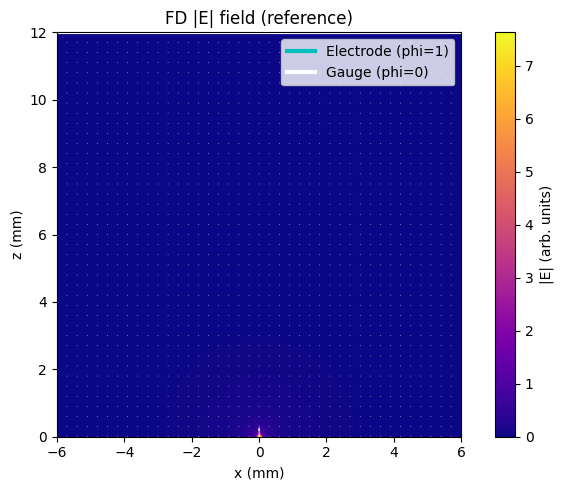

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\pina\trainer.py: UserWarning: Compilation is disabled for Python 3.14+ and for Windows.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 21.1 K | train
1 | _loss_fn     | MSELoss    | 0      | train
----------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
2

[Step 2] Training PINN basis solution...


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


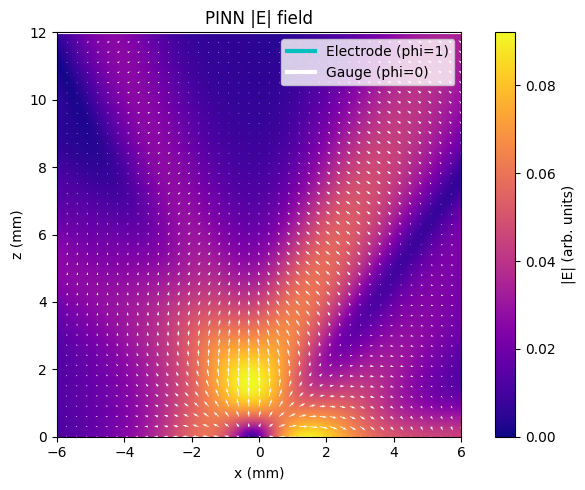

[Step 3] Metrics vs FD baseline...
=== PINN vs FD metrics (lower is better) ===
                phi_rMAE: 1.4942e+01
               phi_rRMSE: 6.2378e+00
              Evec_rRMSE: 1.0241e+00
               |E|_rRMSE: 1.0073e+00
            Laplace_RMSE: 2.3528e-02
       BC_electrode_RMSE: 5.1186e-01
           BC_gauge_RMSE: 1.3704e-01
      BC_bottom_neu_RMSE: 2.4354e-02
         BC_top_neu_RMSE: nan
        BC_left_neu_RMSE: 6.5292e-03
       BC_right_neu_RMSE: 1.7946e-02
            sym_phi_RMSE: 3.7489e-02
[Step 4] Error maps...


c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\numpy\_core\fromnumeric.py: RuntimeWarning: Mean of empty slice.
c:\Users\Melvi\anaconda3\envs\capstone-gpu\Lib\site-packages\numpy\_core\_methods.py: RuntimeWarning: invalid value encountered in divide


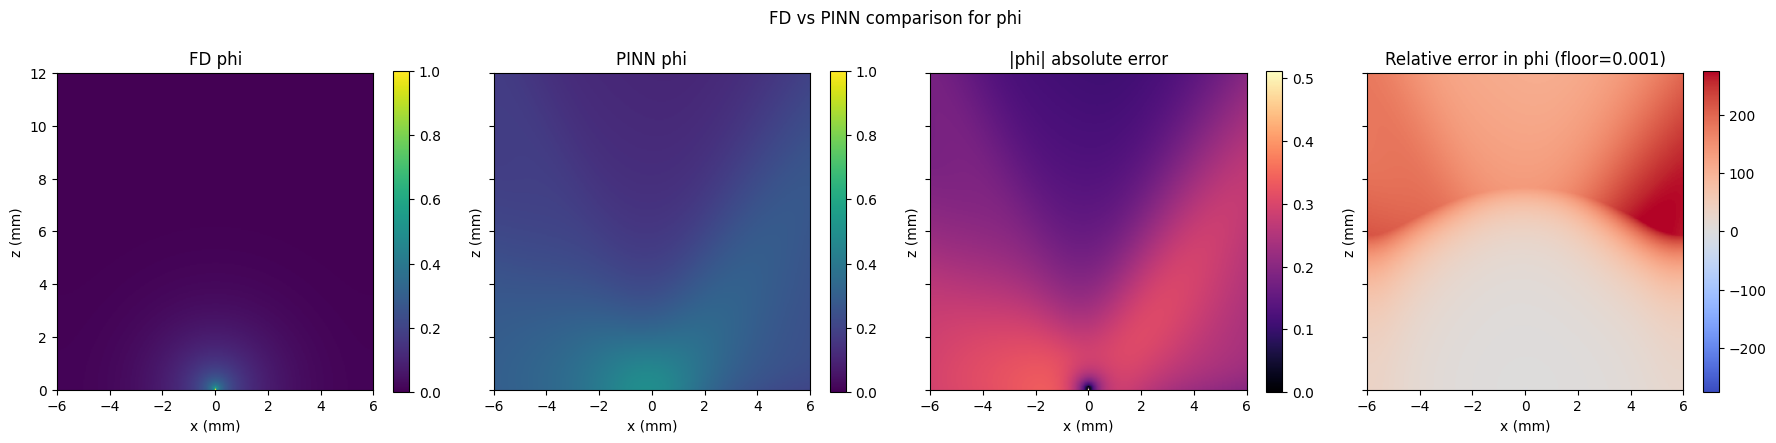

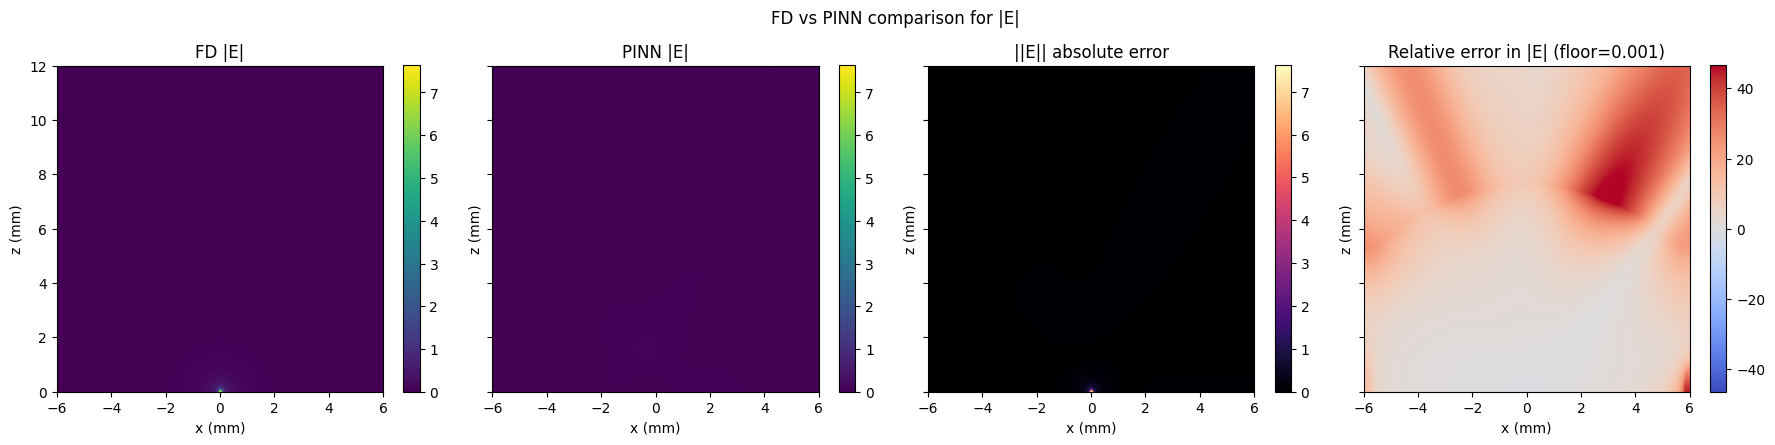

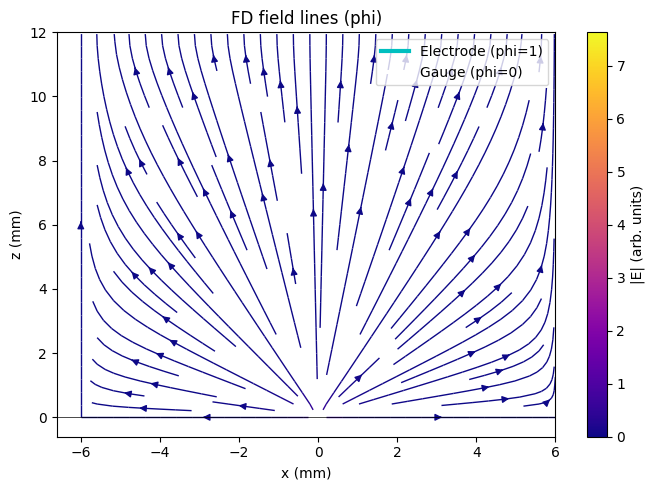

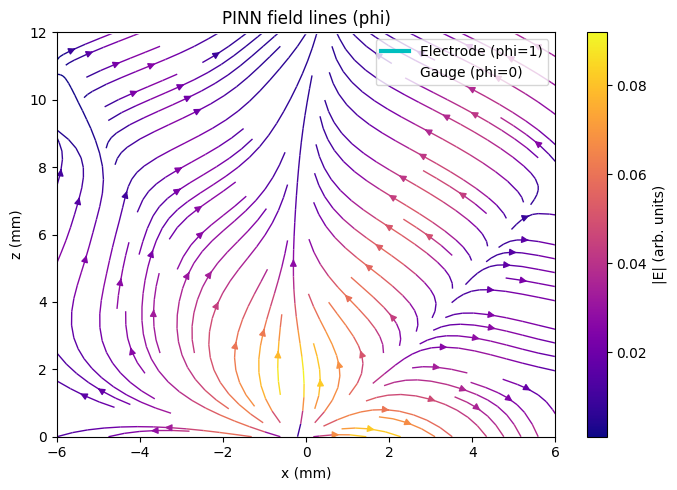

In [47]:
def run_single_electrode_demo(
    *,
    fd_verbose: bool = True,
    pinn_epochs: int = 10,
    plot_vertical: bool = False,
    x_cut_mm: float = 0.0,
    plot_fieldlines: bool = True,
    rel_floor: float = 1e-3,
) -> Dict[str, float]:
    # --- Step 1: FD reference solution ---
    print("[Step 1] Solving FD baseline...")
    phi_fd = solve_laplace_fd(
        electrode_mask,
        gauge_mask_1d=gauge_mask,
        phi_electrode=1.0,
        phi_gauge=0.0,
        max_iters=8000,
        tol=1e-6,
        verbose=fd_verbose,
    )
    check_fd_residual(phi_fd)
    Ex_fd, Ez_fd, Emag_fd = compute_field(phi_fd)

    plot_field_map(
        Emag_fd,
        Ex_fd,
        Ez_fd,
        title="FD |E| field (reference)",
        electrode_mask_1d=electrode_mask,
        gauge_mask_1d=gauge_mask,
        vmax=None,
    )

    # --- Step 2: Train PINN (single-electrode basis) ---
    print("[Step 2] Training PINN basis solution...")
    run = train_pinn_basis(
        interior_points=230_000,
        interior_points_near=None,
        dirichlet_points=1_500,
        neumann_points=8_000,
        max_epochs=pinn_epochs,
        hidden_size=64,
        n_layers=6,
    )
    model = run["model"]

    phi_pinn, Ex_pinn, Ez_pinn, Emag_pinn = compute_field_from_model(model)

    plot_field_map(
        Emag_pinn,
        Ex_pinn,
        Ez_pinn,
        title="PINN |E| field",
        electrode_mask_1d=electrode_mask,
        gauge_mask_1d=gauge_mask,
        vmax=None,
    )

    # --- Step 3: Metrics vs FD ---
    print("[Step 3] Metrics vs FD baseline...")
    metrics = evaluate_against_fd(model, phi_fd, print_report=True)

    # --- Step 4: Difference / error plots ---
    print("[Step 4] Error maps...")
    plot_fd_vs_pinn_difference(phi_fd, phi_pinn, quantity="phi", rel_floor=rel_floor, show_abs=True)
    plot_fd_vs_pinn_difference(phi_fd, phi_pinn, quantity="|E|", rel_floor=rel_floor, show_abs=True)

    if plot_vertical:
        plot_vertical_cut(phi_fd, phi_pinn, x0=x_cut_mm)

    if plot_fieldlines:
        plot_field_lines(phi_fd, title="FD field lines (phi)")
        plot_field_lines(phi_pinn, title="PINN field lines (phi)")

    return metrics


# If you want to run immediately in a script:
if __name__ == "__main__":
    metrics = run_single_electrode_demo(pinn_epochs=10)
